In [ ]:
from google.colab import drive
from os import listdir

import pandas as pd

# basepath
dir_path = "/content/drive/MyDrive/2024-02-machine-learning/data"
file_name = "coffee-202305-202311.csv"

# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 시작하기 전

- 동대문구 각 행정동의 유동인구 데이터를 일단 하나로 합쳐서 `foot_traffic_dongdaemun.csv` 에 저장한다.

# 정리할 내용

- centroid 정확성을 고려한 계산


In [ ]:
# read all .csv from foot_traffic_data dir
# and extract .csv extensions from this list
csv_file_list = [file for file in listdir(f'{dir_path}/foot_traffic_data') if file.endswith('.csv')]

In [ ]:
# then, read all csv file list with dir_path with DataFrame
# and merge them into one dataframe
df_seoul_foot_traffic = pd.DataFrame()

for file in csv_file_list:
  df_seoul_foot_traffic = pd.concat([df_seoul_foot_traffic, pd.read_csv(f'{dir_path}/foot_traffic_data/{file}')])

# finally, save it into same dir with foot_traffic_dongdaemun.csv
df_seoul_foot_traffic.to_csv(f'{dir_path}/foot_traffic_data/foot_traffic_dongdaemun.csv', index=False)

- 저장이 완료된 뒤, `df_seoul_foot_traffic` 을 통해 유동인구 데이터를 처리한다.

In [ ]:
df_seoul_foot_traffic = pd.read_csv(f'{dir_path}/foot_traffic_data/foot_traffic_dongdaemun.csv')

In [ ]:
df_seoul_foot_traffic

,STDR_YM_CD,RD_LINK_ID,SIGNGU_CD,ADSTRD_CD,DAYWEEK_CD,AGRDE_CD,TMZON_CD,FLPOP_CO
0,201601,57447,11230,11230536,1,0,0,238.162875
1,201601,57447,11230,11230536,1,0,1,0.000000
2,201601,57447,11230,11230536,1,0,2,37.109375
3,201601,57447,11230,11230536,1,0,3,66.919250
4,201601,57447,11230,11230536,1,0,4,67.507500
...,...,...,...,...,...,...,...,...
10912540,201609,34608,11230,11230750,2,60,2,2.660000
10912541,201609,34608,11230,11230750,2,60,3,3.620000
10912542,201609,34608,11230,11230750,2,60,4,3.575000
10912543,201609,34608,11230,11230750,2,60,5,5.620000


# 도로 링크를 통해 위치 데이터와 연결

- geopandas 를 이용해 .shp 파일을 읽는다.
- 유의할 점은 데이터 캠퍼스에서 가져온 데이터셋의 좌표계가 Korea 2000 / Central Belt(EPSG : 5181)이고, 카카오맵의 좌표계는 WGS84 라는 점이다.
  - 그리고, WGS84 는 EPSG:4326 을 사용한다.
- 따라서 해야 할 일들을 적어보자면 다음과 같다.
  - .shp 파일의 LineString 에 있는 Geolocation data 좌표계를 EPSG:4326 로 변경
  - centroid(중간지점) 추출
  - 도로 링크를 기반으로 위도/경도 JOIN

# 우려되는 점
- [위도/경도 데이터가 2016년 3월 기준으로 변경](https://bigdata.seoul.go.kr/data/selectSampleData.do?r_id=P213&sample_data_seq=32&tab_type=&file_id=&sch_text=%EC%84%9C%EC%9A%B8%EC%8B%9C+10m+%EB%8F%84%EB%A1%9C%EA%B5%AC%EA%B0%84%EB%B3%84+%EC%B6%94%EC%A0%95+%EC%9C%A0%EB%8F%99%EC%9D%B8%EA%B5%AC+%EB%8D%B0%EC%9D%B4%ED%84%B0&sch_order=U&currentPage=1)된 상황에서 .shp 파일의 기준 년/월이 STDR_YM_CD 이라는 점이다.
- 제대로 맞지 않는지를 확인하고 제대로 맞지 않는다면 2016년 최신 기준의 .shp 파일을 다시 가서 반출해야 한다.
- 그러나 현실적으로 그러기는 어렵기에, 일단은 `STDR_YM_CD` col 이 `201605` 인 것들만을 우선 골라준다.  

In [ ]:
df_seoul_foot_traffic_201605 = df_seoul_foot_traffic[df_seoul_foot_traffic['STDR_YM_CD'] == 201605]

In [ ]:
df_seoul_foot_traffic_201605

,STDR_YM_CD,RD_LINK_ID,SIGNGU_CD,ADSTRD_CD,DAYWEEK_CD,AGRDE_CD,TMZON_CD,FLPOP_CO
1110552,201605,57583,11230,11230536,1,0,0,257.3732
1110553,201605,57583,11230,11230536,1,0,1,0.5476
1110554,201605,57583,11230,11230536,1,0,2,40.6968
1110555,201605,57583,11230,11230536,1,0,3,64.5174
1110556,201605,57583,11230,11230536,1,0,4,65.7552
...,...,...,...,...,...,...,...,...
10800428,201605,37598,11230,11230750,2,10,1,0.0000
10800429,201605,37598,11230,11230750,2,10,2,0.1035
10800430,201605,37598,11230,11230750,2,10,3,0.9030
10800431,201605,37598,11230,11230750,2,10,4,0.8090


In [ ]:
import geopandas as gpd

# and read TBGIS_ROAD_LINK_FRM (1).shx file in geolocation_data dir
df_road_link = gpd.read_file(f'{dir_path}/geolocation_data/TBGIS_ROAD_LINK_FRM (1).shp', encoding='cp949').to_crs(epsg=5181)

In [ ]:
df_road_link

,ROAD_LID,ROAD_CD,STDR_YM_CD,geometry
0,1,411503000001,201605,"LINESTRING (205227.085 467813.314, 205242.614 ..."
1,2,411503181063,201605,"LINESTRING (203970.9 466152.07, 203971.511 466..."
2,3,113203109009,201605,"LINESTRING (203958.211 466031.99, 203958.227 4..."
3,4,113204127309,201605,"LINESTRING (203895.135 465994.69, 203878.256 4..."
4,5,411503181063,201605,"LINESTRING (203971.257 465878.119, 203968.937 ..."
...,...,...,...,...
180455,180456,412902000004,201605,"LINESTRING (197998.245 433759.047, 198001.447 ..."
180456,180457,411311000027,201605,"LINESTRING (206758.288 432949.045, 206760.899 ..."
180457,180458,411353180005,201605,"LINESTRING (209037.477 427147.068, 209032.841 ..."
180458,180459,411352000005,201605,"LINESTRING (209658.753 426294.512, 209657.489 ..."


In [ ]:
df_road_link_to_wsg = df_road_link.to_crs(epsg=4326)

In [ ]:
df_road_link_to_wsg.drop(columns=['centroid'])

,ROAD_LID,ROAD_CD,STDR_YM_CD,geometry
0,1,411503000001,201605,"LINESTRING (127.05928 37.71, 127.05946 37.7103..."
1,2,411503181063,201605,"LINESTRING (127.04502 37.69504, 127.04503 37.6..."
2,3,113203109009,201605,"LINESTRING (127.04488 37.69396, 127.04488 37.6..."
3,4,113204127309,201605,"LINESTRING (127.04416 37.69362, 127.04397 37.6..."
4,5,411503181063,201605,"LINESTRING (127.04503 37.69257, 127.045 37.692..."
...,...,...,...,...
180455,180456,412902000004,201605,"LINESTRING (126.97739 37.40318, 126.97743 37.4..."
180456,180457,411311000027,201605,"LINESTRING (127.07632 37.39586, 127.07635 37.3..."
180457,180458,411353180005,201605,"LINESTRING (127.10199 37.34357, 127.10194 37.3..."
180458,180459,411352000005,201605,"LINESTRING (127.10899 37.33588, 127.10898 37.3..."


In [ ]:
# add centroid col
df_road_link['centroid'] = df_road_link['geometry'].centroid

In [ ]:
# create another geodataframe based on centroid and convert them into ESPG:4326
df_road_link_centroid_to_wsg = gpd.GeoDataFrame(df_road_link, geometry='centroid').to_crs(epsg=4326)
df_road_link_centroid_to_wsg.set_geometry('centroid', inplace=True)
df_road_link_centroid_to_wsg.drop(columns=['geometry'])

,ROAD_LID,ROAD_CD,STDR_YM_CD,centroid
0,1,411503000001,201605,POINT (127.05529 37.73738)
1,2,411503181063,201605,POINT (127.04643 37.72985)
2,3,113203109009,201605,POINT (127.04495 37.6945)
3,4,113204127309,201605,POINT (127.04345 37.69368)
4,5,411503181063,201605,POINT (127.04495 37.69326)
...,...,...,...,...
180455,180456,412902000004,201605,POINT (126.9926 37.42406)
180456,180457,411311000027,201605,POINT (127.08778 37.40243)
180457,180458,411353180005,201605,POINT (127.10265 37.37666)
180458,180459,411352000005,201605,POINT (127.12127 37.40045)


In [ ]:
df_road_link_centroid_to_wsg_ddm = df_road_link_centroid_to_wsg[
    df_road_link_centroid_to_wsg['ROAD_LID'].astype('int').isin(df_seoul_foot_traffic_201605['RD_LINK_ID'].astype('int').unique())
]

In [ ]:
df_road_link_centroid_to_wsg_ddm

,ROAD_LID,ROAD_CD,STDR_YM_CD,geometry,centroid
32062,32063,112904121475,201605,"LINESTRING (205718.085 456241.48, 205727.111 4...",POINT (127.06487 37.60576)
32148,32149,112904121475,201605,"LINESTRING (205697.894 456229.952, 205718.085 ...",POINT (127.06464 37.60568)
32229,32230,112904121475,201605,"LINESTRING (205678.882 456219.124, 205697.894 ...",POINT (127.06442 37.60558)
32245,32246,112904121475,201605,"LINESTRING (205738.649 456244.386, 205740.497 ...",POINT (127.06517 37.60565)
32317,32318,112904121475,201605,"LINESTRING (205658.691 456207.596, 205678.882 ...",POINT (127.0642 37.60548)
...,...,...,...,...,...
84993,84994,112304115576,201605,"LINESTRING (206173.151 451246.302, 206208.169 ...",POINT (127.07009 37.5611)
84994,84995,112002000008,201605,"LINESTRING (206026.824 451273.187, 206173.151 ...",POINT (127.06904 37.56085)
85212,85213,112303105011,201605,"LINESTRING (206252.279 451231.767, 206261.003 ...",POINT (127.07094 37.56092)
85213,85214,112002000008,201605,"LINESTRING (206173.151 451246.302, 206252.279 ...",POINT (127.07032 37.56066)


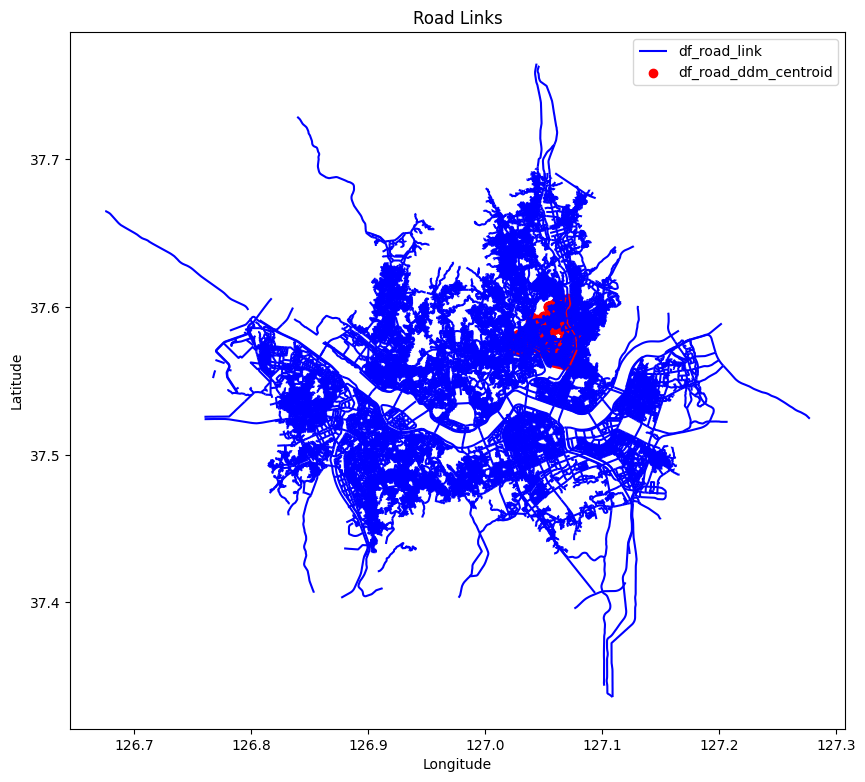

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_road_link and df_road_link_ddm are GeoDataFrames
# and have a geometry column representing the road links

fig, ax = plt.subplots(figsize=(10, 10))

# Plot df_road_link in blue
df_road_link_to_wsg.plot(ax=ax, color='blue', label='df_road_link')

# Plot df_road_link_ddm in red
df_road_link_centroid_to_wsg_ddm.plot(ax=ax, color='red', label='df_road_ddm_centroid')

# Add labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Road Links")
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_road_link_centroid_to_wsg_ddm['x'] = df_road_link_centroid_to_wsg_ddm['centroid'].x.astype(float)
df_road_link_centroid_to_wsg_ddm['y'] = df_road_link_centroid_to_wsg_ddm['centroid'].y.astype(float)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
df_road_link_centroid_to_wsg_ddm

,ROAD_LID,ROAD_CD,STDR_YM_CD,geometry,centroid,x,y
32062,32063,112904121475,201605,"LINESTRING (205718.085 456241.48, 205727.111 4...",POINT (127.06487 37.60576),127.064872,37.605760
32148,32149,112904121475,201605,"LINESTRING (205697.894 456229.952, 205718.085 ...",POINT (127.06464 37.60568),127.064643,37.605684
32229,32230,112904121475,201605,"LINESTRING (205678.882 456219.124, 205697.894 ...",POINT (127.06442 37.60558),127.064421,37.605583
32245,32246,112904121475,201605,"LINESTRING (205738.649 456244.386, 205740.497 ...",POINT (127.06517 37.60565),127.065165,37.605649
32317,32318,112904121475,201605,"LINESTRING (205658.691 456207.596, 205678.882 ...",POINT (127.0642 37.60548),127.064199,37.605483
...,...,...,...,...,...,...,...
84993,84994,112304115576,201605,"LINESTRING (206173.151 451246.302, 206208.169 ...",POINT (127.07009 37.5611),127.070092,37.561103
84994,84995,112002000008,201605,"LINESTRING (206026.824 451273.187, 206173.151 ...",POINT (127.06904 37.56085),127.069041,37.560848
85212,85213,112303105011,201605,"LINESTRING (206252.279 451231.767, 206261.003 ...",POINT (127.07094 37.56092),127.070944,37.560919
85213,85214,112002000008,201605,"LINESTRING (206173.151 451246.302, 206252.279 ...",POINT (127.07032 37.56066),127.070316,37.560661


In [ ]:
df_seoul_foot_traffic_201605.join(
    df_road_link_centroid_to_wsg_ddm['ROAD_LID', 'x', 'y'].set_index('ROAD_LID'),
    on='RD_LINK_ID'
)

,STDR_YM_CD,DAYWEEK_CD,AGRDE_CD,TMZON_CD,FLPOP_CO,ROAD_CD,x,y
1110552,201605,1,0,0,257.3732,112304115228,127.028785,37.581983
1110553,201605,1,0,1,0.5476,112304115228,127.028785,37.581983
1110554,201605,1,0,2,40.6968,112304115228,127.028785,37.581983
1110555,201605,1,0,3,64.5174,112304115228,127.028785,37.581983
1110556,201605,1,0,4,65.7552,112304115228,127.028785,37.581983
...,...,...,...,...,...,...,...,...
10800428,201605,2,10,1,0.0000,112904121230,127.020275,37.599033
10800429,201605,2,10,2,0.1035,112904121230,127.020275,37.599033
10800430,201605,2,10,3,0.9030,112904121230,127.020275,37.599033
10800431,201605,2,10,4,0.8090,112904121230,127.020275,37.599033


In [ ]:
# save df_foot_traffic_with_geolocation_trimmed dataframe
df_foot_traffic_with_geolocation_trimmed.to_csv(f'{dir_path}/foot_traffic_dongdaemun_with_geolocation_201605.csv', index=False)

In [ ]:
# drop duplicates by col 'ROAD_CD'
df_foot_traffic_with_geolocation_trimmed_without_duplicates = df_foot_traffic_with_geolocation_trimmed.drop_duplicates(subset=['ROAD_CD'])

In [ ]:
# Create a POINT data with df_foot_traffic_with_geolocation_trimmed[['x', 'y']]
# Create a GeoDataFrame with the points

from shapely.geometry import Point

geodataframe = df_foot_traffic_with_geolocation_trimmed_without_duplicates[['x', 'y']]
geodataframe['geometry'] = geodataframe.apply(lambda row: Point(row['x'], row['y']), axis=1)
geodataframe = gpd.GeoDataFrame(geodataframe, geometry='geometry')

<ipython-input-146-239586be4b4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodataframe['geometry'] = geodataframe.apply(lambda row: Point(row['x'], row['y']), axis=1)


In [ ]:
# then save it
df_foot_traffic_with_geolocation_trimmed.to_csv(f'{dir_path}/foot_traffic_dongdaemun_with_geolocation.csv', index=False)

In [ ]:
# read TL_SPRD_MANAGE.shp from geolocation_data dir

df_check_geolocation_data = gpd.read_file(f'{dir_path}/geolocation_data/TL_SPRD_MANAGE.shp', encoding='cp949')

In [ ]:
# find a record from df_check_geolocation_data where ROAD_CD column's value is 112304115228

test_result = df_check_geolocation_data_compatible_with_wgs84[df_check_geolocation_data_compatible_with_wgs84['ROAD_CD'] == '112304115228']

In [ ]:
test_result

,BSI_INT,ENG_RN,NTFC_DE,RBP_CN,RDS_DPN_SE,RDS_MAN_NO,REP_CN,RN,RN_CD,ROAD_BT,...,ROA_CLS_SE,SIG_CD,WDR_RD_CD,XMIN,YMIN,XMAX,YMAX,STD_YMD,ROAD_CD,geometry
24824,10,Anam-ro 16-gil,20100617,용두동 728-1,0,1025.0,용두동 193-70,안암로16길,4115228,8.0,...,4,11230,3,314404,553605,314453,553757,None,112304115228,"LINESTRING (127.02867 37.58209, 127.0289 37.58..."


In [ ]:
test_result_x = test_result['geometry'].centroid.x.astype(float)
test_result_y = test_result['geometry'].centroid.y.astype(float)

<ipython-input-88-5e453fea45f8>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  test_result_x = test_result['geometry'].centroid.x.astype(float)
<ipython-input-88-5e453fea45f8>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  test_result_y = test_result['geometry'].centroid.y.astype(float)


In [ ]:
test_result_x, test_result_y

(24824    127.029038
 dtype: float64,
 24824    37.581465
 dtype: float64)

In [ ]:
df_road_link_compatible_with_wgs84[df_road_link_compatible_with_wgs84['ROAD_CD'] == '112304115228']

,RD_LINK_ID,ROAD_CD,STDR_YM_CD,geometry,x,y
57447,57448,112304115228,201501,"LINESTRING (127.02867 37.58209, 127.0289 37.58...",127.028785,37.581983
57690,57691,112304115228,201501,"LINESTRING (127.0289 37.58187, 127.02905 37.58...",127.028989,37.581782
58013,58014,112304115228,201501,"LINESTRING (127.02905 37.58168, 127.02905 37.5...",127.029064,37.581553
58383,58384,112304115228,201501,"LINESTRING (127.02909 37.58143, 127.02915 37.5...",127.029119,37.581285
58913,58914,112304115228,201501,"LINESTRING (127.02915 37.58114, 127.02923 37.5...",127.029190,37.580941


In [ ]:
gpd.